In [1]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import cv2
from skimage import color
from scipy.ndimage import binary_fill_holes
from skimage import exposure
from tifffile import imread, imwrite

In [48]:
def histogram_equalize(img, mask):
    #img = rgb2gray(img)
    #img_cdf, bin_centers = exposure.cumulative_distribution(img)
    #new_img = np.interp(img, bin_centers, img_cdf)
    #new_img = new_img * 45000 
    #return new_img.astype(np.uint16)
    img = exposure.equalize_hist(img, mask=mask)
    data = img / np.max(img) # normalize the data to 0 - 1
    del img
    data = 65535 * data # Now scale by 255
    return data.astype(np.uint16)    

def scaled(data, upper=65535):
    #_max = np.quantile(data[data>0], epsilon)
    #_max = np.max(data)
    _max = 1642
    data = data.astype(np.float64) / _max # 
    data = upper * data 
    img = data.astype(np.uint16)
    return img, _max


def rescaler(img, lower, upper):
    # Contrast stretching
    plower, pupper = np.percentile(img, (lower, upper))
    _max = np.max(pupper)
    img_rescale = exposure.rescale_intensity(img, in_range=(plower, pupper))
    #img_rescale = exposure.rescale_intensity(img, out_range=(lower, upper))
    return img_rescale, _max

def normalize_image(img):
    """This is a simple opencv image normalization for 16 bit images.

    :param img: the numpy array of the 16bit image
    :return img: the normalized image
    """
    #img = img[img > 0]
    #print(f'normalize image shape={img.shape}')
    max = 2 ** 16 - 1 # 16bit
    cv2.normalize(img, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    return img


def equalized(fixed, cliplimit=2):    
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(8, 8))
    fixed = clahe.apply(fixed)
    return fixed

def clean(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)

def match_histograms(cleaned):
    referencepath = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK161/preps/scaled_upper_99.9_max_1642.0_046.tif'
    #shapeto = cleaned.shape
    reference = imread(referencepath)
    #reference = reference.flatten()
    #cleaned = cleaned.flatten()
    img = exposure.match_histograms(cleaned, reference)
    print(f'img dtype after match={img.dtype}')
    #img = img.reshape(shapeto)
    data = img / np.max(img) # normalize the data to 0 - 1
    del img
    data = 65535 * data # Now scale by 255
    return data.astype(np.uint16)    
    #return img

In [34]:
basepath = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'
allenpath = os.path.join(basepath, 'Allen_25um_sagittal.tif')
allenarr = io.imread(allenpath)
print(f'allen dtype={allenarr.dtype} shape={allenarr.shape}')

allen dtype=uint16 shape=(456, 450, 675)


In [49]:
midpoint = allenarr.shape[0] // 2
midallenarr = allenarr[midpoint, ...]
print(f'mid allen dtype={midallenarr.dtype} shape={midallenarr.shape}')
#del allenarr

mid allen dtype=uint16 shape=(450, 675)


In [50]:
matched = match_histograms(midallenarr)
print(matched.dtype)

img dtype after match=float64
uint16


In [ ]:
outpath = os.path.join(basepath, 'Allen_25um_sagittal_mid.tif')
print(outpath)
imwrite(outpath, midallenarr, compression='LZW', bigtiff=True)

In [3]:
animal = 'DK161'
file = '046.tif'
BASE_DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
filepath = os.path.join(BASE_DIR, 'C2/full', file)
maskpath = os.path.join(BASE_DIR, 'masks/C1/full_masked', file)

In [4]:
#For bigarr, look at 15812x43685, 16816x44463
startrow = 31000
endrow = 33000
startcol = 8000
endcol = 12000

In [8]:
img = io.imread(filepath)
print(f'dtype={img.dtype} shape={img.shape}')
mask = io.imread(maskpath)
print(f'dtype={mask.dtype} shape={mask.shape}')

dtype=uint16 shape=(46181, 25956)
dtype=uint8 shape=(46181, 25956)


In [9]:
cleaned = clean(img, mask)
del img
del mask
print(f'dtype={cleaned.dtype} shape={cleaned.shape}')

dtype=uint16 shape=(46181, 25956)


cleaned_scaled dtype=uint16
CPU times: user 6.48 s, sys: 2.62 s, total: 9.1 s
Wall time: 9.1 s


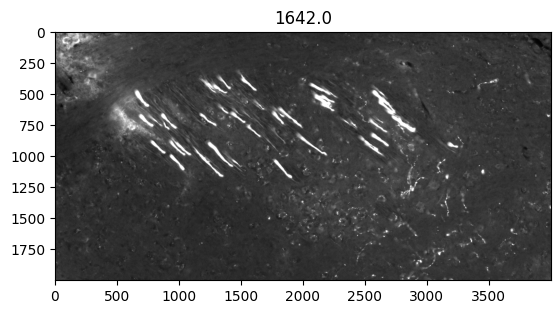

In [16]:
%%time
lower = 0
upper = 99.9
epsilon = 0.999
#cleaned_scaled, _max = scaled(cleaned, upper)
cleaned_scaled, _max = rescaler(cleaned, lower, upper)
#cleaned_scaled = histogram_equalize(img, mask)
print(f'cleaned_scaled dtype={cleaned_scaled.dtype}')
cropped = cleaned_scaled[startrow:endrow, startcol:endcol]
plt.title(_max)
plt.imshow(cropped, cmap="gray")

In [17]:
#outpath = os.path.join(BASE_DIR, f'rescaler_upper_{upper}_lower_{lower}_{file}')
outpath = os.path.join(BASE_DIR, f'scaled_upper_{upper}_max_{_max}_{file}')
print(outpath)
imwrite(outpath, cleaned_scaled, compression='LZW', bigtiff=True)

/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK161/preps/scaled_upper_99.9_max_1642.0_046.tif


In [ ]:
%%time
shapeto = cleaned.shape
reference = midallenarr[midallenarr > 0]
reference = reference.flatten()
target = cleaned.flatten()
matched = exposure.match_histograms(target, reference)

In [ ]:
%%time
matched = match_histograms(cleaned, midallenarr)
print(f'matched dtype={matched.dtype} shape={matched.shape}')

In [ ]:
#matched = matched.reshape(shapeto)
print(f'matched dtype={matched.dtype}')
cropped = matched[startrow:endrow, startcol:endcol]
plt.title('matched')
plt.imshow(cropped, cmap="gray")

In [ ]:
data = matched / np.max(matched) # normalize the data to 0 - 1
data = 65535 * data # Now scale by 255
outpath = os.path.join(BASE_DIR, f'matched_{file}')
print(outpath)
imwrite(outpath, data.astype(np.uint16), compression='LZW', bigtiff=True)

In [ ]:
img = midallenarr.copy()
img = img[img > 0]
flat = img.flatten()
del img
fig = plt.figure()
plt.rcParams["figure.figsize"] = [10, 6]
end = np.max(flat)
end = 2000
plt.hist(flat, flat.max(), [0, 5000], color='b')
plt.style.use("ggplot")
plt.grid(axis="y", alpha=0.75)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
newimg = clean(img, mask)
white = np.where(mask==255)
whiterows = white[0]
firstrow = whiterows[1]
print(firstrow)
print(np.max(newimg[firstrow]))

print(f'dtype={newimg.dtype} shape={newimg.shape} first={first}')
newimg[newimg[:,:,0] == 0] = 234
plt.imshow(newimg)

In [ ]:
scale = 45000
cropped_scaled = scaled(cropped, scale)
print(f'dtype={cropped_scaled.dtype} shape={cropped_scaled.shape}')

In [ ]:
plt.imshow(cropped_scaled, cmap="gray")

In [ ]:
outpath = os.path.join(BASE_DIR, 'cropped_test.tif')
io.imsave(outpath, cropped_scaled)

In [ ]:
scale = 2**16 - 1
cropped_scaled = scaled(cropped, scale)
outpath = os.path.join(DIR, f'cropped_scaled_{scale}.tif')
if not os.path.exists(outpath):
    io.imsave(outpath, cropped_scaled)